In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np

In [0]:
from tqdm import tqdm

In [0]:
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )
groups = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/train_groups.csv",
     sep=","
     )

In [0]:
titles.head()

,doc_id,title
0,15731,ВАЗ 21213 | Замена подшипников ступицы | Нива
1,14829,"Ваз 2107 оптом в Сочи. Сравнить цены, купить п..."
2,15764,Купить ступица Лада калина2. Трансмиссия - пер...
3,17669,Классика 21010 - 21074
4,14852,Ступица Нива — замена подшипника своими руками


In [0]:
groups.head()

,pair_id,group_id,doc_id,target
0,1,1,15731,0
1,2,1,14829,0
2,3,1,15764,0
3,4,1,17669,0
4,5,1,14852,0


In [0]:
dct = {}
for (doc_id, title) in zip(titles.doc_id, titles.title):
  dct[doc_id] = title
titles_to_merge = []
for doc_id in groups.doc_id:
  titles_to_merge.append(dct[doc_id])
docs_merged = groups.copy()
docs_merged["title"] = pd.Series(titles_to_merge)

In [0]:
with open("titles_merged.csv", "w") as f:
  f.write(docs_merged.to_csv())
docs_merged.head()

,pair_id,group_id,doc_id,target,title
0,1,1,15731,0,ВАЗ 21213 | Замена подшипников ступицы | Нива
1,2,1,14829,0,"Ваз 2107 оптом в Сочи. Сравнить цены, купить п..."
2,3,1,15764,0,Купить ступица Лада калина2. Трансмиссия - пер...
3,4,1,17669,0,Классика 21010 - 21074
4,5,1,14852,0,Ступица Нива — замена подшипника своими руками


In [0]:
docs_merged.title = docs_merged.title.fillna("")
X = docs_merged["title"]
y = docs_merged["target"]

Я там нашел 16 отсутствующих заголовков. Их мало, и потому я слегка забил и заполнил их пустотой, подумав, что в этом есть некоторый физический смысл

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=2.0)
vectorizer.fit(X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=2.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

А сейчас попробуем сделать какие-то фичи на основе попарных расстояний

In [0]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

In [0]:
groups_indixes = groups.group_id.unique()
X_train = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      docs_merged[docs_merged.group_id == group_id].title
      )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:21:]
  X_train.append(features)
X_train = np.vstack(X_train)
X_train = StandardScaler().fit_transform(X_train)

In [0]:
X_train.shape

(11690, 20)

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20,10)

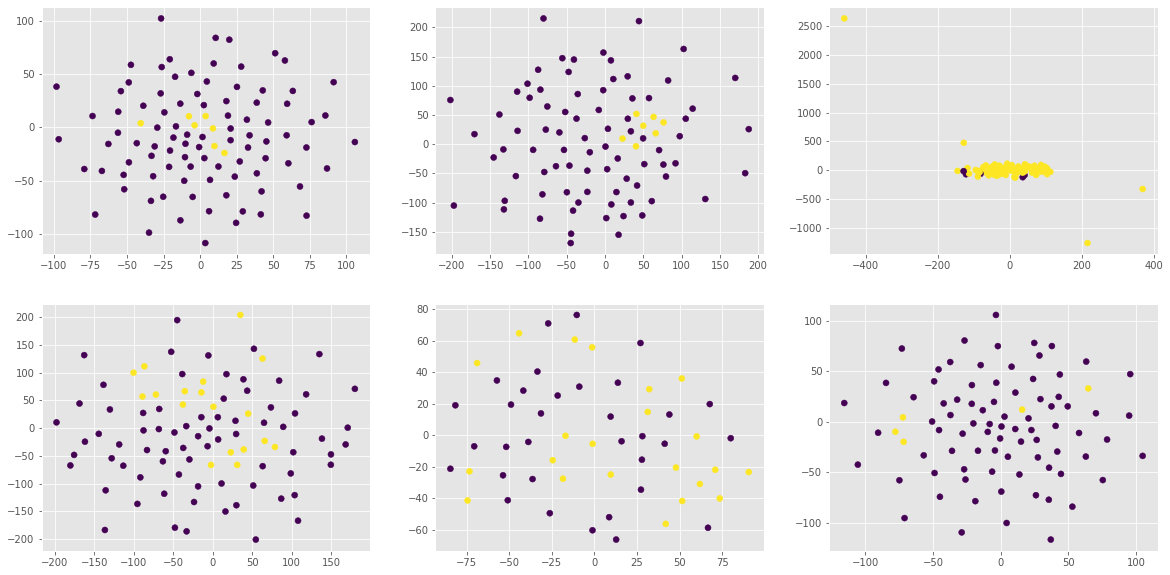

In [0]:
y = docs_merged.target

for (i, group) in enumerate([39, 4, 100, 14, 48, 63]):
  X_embedded = TSNE(
      n_components=2,
      metric='cosine'
      ).fit_transform(
      vectorizer.transform(
          docs_merged[docs_merged.group_id == group].title
          ).toarray(),
      )
  plt.subplot(2, 3, i + 1)
  plt.scatter(X_embedded[::, 0], X_embedded[::, 1],
              c=y[docs_merged.group_id == group])
plt.show()

Возможно, делится не так уж и хорошо...

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from  sklearn.linear_model import LogisticRegressionCV
from  sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupKFold

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [0]:
# нужно, чтобы пихать в стандартные CV
class MyFoldGenerator:
  def __init__(self, groups, n_splits=1, cv=None):
    self.__n_splits = n_splits
    self.__groups = groups
    if cv is not None:
      self.__cv = cv
    else:
      self.__cv = LeavePGroupsOut(self.__n_splits) 
  def split(self, X, y, *args):
    yield from self.__cv.split(X, y, self.__groups)
  def get_n_splits(self, X, y, *args):
    return self.__cv.get_n_splits(X, y, self.__groups)

In [0]:
def cross_validation(
    model, X, y, groups, cv=None,
    score_func=f1_score, treshold=None, 
    use_tqdm=True
    ):
  score = 0
  if cv is None:
    cv = LeavePGroupsOut(1)
  seq = cv.split(X, y, groups)
  if use_tqdm:
    seq = tqdm(list(seq))
  count = 0
  for (train, test) in seq:
    model.fit(X[train], y[train])
    if treshold is not None:
      score += score_func(
          y[test], model.predict(X[test]) > treshold
          ) * y[test].shape[0]
    else:
      score += score_func(
          y[test], model.predict(X[test])
          ) * y[test].shape[0]
    count += 1
  return score / y.shape[0]

In [0]:
cv = MyFoldGenerator(groups=docs_merged.group_id, cv=GroupKFold(10))

In [0]:
clf = RidgeCV(
    alphas=np.logspace(0.1, 10, 100),
    cv=cv, scoring="roc_auc"
    ).fit(X_train, y)
clf_ridge = Ridge(alpha=clf.alpha_)
cross_validation(
    clf_ridge, X_train[::, ::], y, docs_merged.group_id,
     cv, roc_auc_score, use_tqdm=False
     )

0.8722506909618358

100%|██████████| 35/35 [00:03<00:00,  9.45it/s]


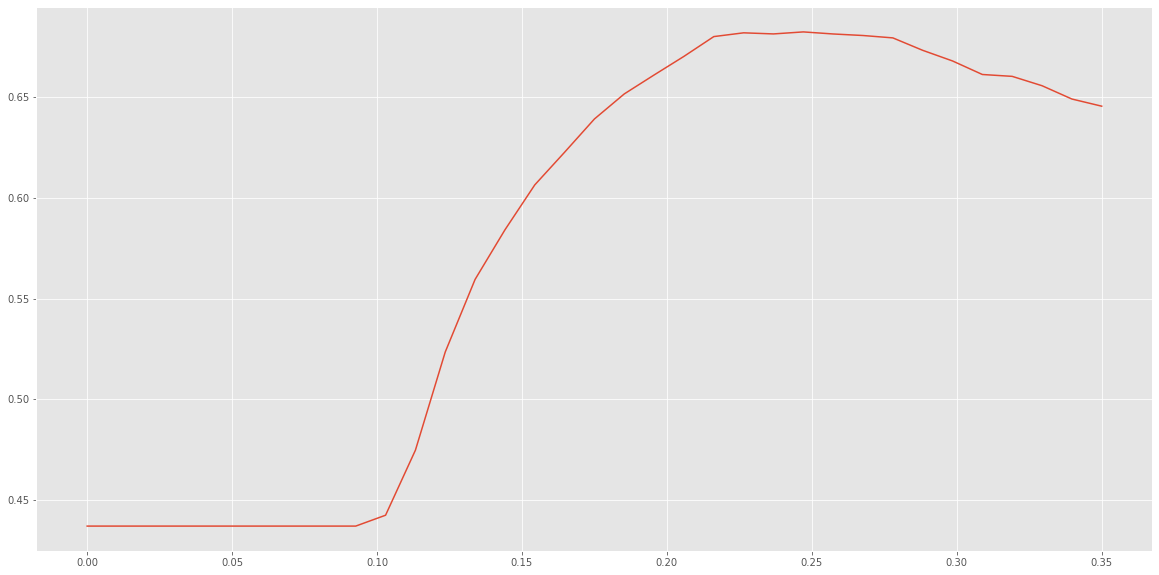

In [0]:
trs, scores = [], []
for treshold in tqdm(np.linspace(0, 0.35, 35)):
  scores.append(cross_validation(
    clf_ridge, X_train[::, ::], y, docs_merged.group_id,
    cv, f1_score, treshold=treshold, use_tqdm=False
    ))
  trs.append(treshold)
plt.plot(trs, scores)
plt.show()

In [0]:
!pip install pymorphy2

Хочу попробовать лемминг

In [0]:
import pymorphy2

In [0]:
morph = pymorphy2.MorphAnalyzer()

Попробуем пока забить на слова, которые не будут русскими. И на числа тоже пока. Вообще слово у нас пока будет довольно простое -- строчные буквы + мб дефис. Пока никаких аббревиатур и прочих радостей

In [0]:
import re

In [0]:
# pattern = re.compile(r'[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
pattern = re.compile(
    (r'[a-z]+\-?[a-z]*\.[a-z]{2}|[а-я]+\-?[а-я]*\.[а-я]{2}|'
    '[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
)

In [0]:
titles = list(map(
    lambda title: re.findall(pattern, title.lower()),
    docs_merged.title)
)

In [0]:
lemmed_titles = []
all_words = set()
for title in titles:
  lemmed_title = []
  for word in title:
    all_words.add(word)
    lemmed_title.append(morph.parse(word)[0].normal_form)
  lemmed_titles.append(lemmed_title)
titles = np.asarray(list(map(" ".join, lemmed_titles)))

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), token_pattern=pattern)
vectorizer.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False,
                token_pattern=re.compile('[a-z]+\\-?[a-z]*\\.[a-z]{2}|[а-я]+\\-?[а-я]*\\.[а-я]{2}|[а-я]+\\-?[а-я]*|[a-z]+\\-?[a-z]*|[0-9]+'),
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
pattern.findall("грамота.рф")

['грамота.рф']

In [0]:
vectorizer.get_feature_names()[10000::]

['excel скачать',
 'excel скачать бесплатно',
 'excel скорый',
 'excel скорый компьютерный',
 'excel студопедия',
 'excel управление',
 'excel управление файл',
 'excelsior',
 'excelsior челентать',
 'excelsior челентать франко',
 'exceltip',
 'exclusive',
 'exclusive content',
 'exclusive content ps',
 'exdom',
 'exdom 2',
 'exdom 2 ru',
 'exe',
 'exe 7',
 'exe 7 96',
 'exe и',
 'exe и как',
 'exe скачать',
 'exe скачать для',
 'exe скачать код',
 'executive-kino',
 'expert',
 'expert русский',
 'expert русский drift',
 'expertoza',
 'experts',
 'explorer',
 'explorer от',
 'explorer от 2005',
 'express',
 'extended',
 'extended weapon',
 'extended weapon mods',
 'extension',
 'external',
 'external usb',
 'external usb hard',
 'extract.ru',
 'extract.ru форум',
 'extract.ru форум теория',
 'extreme',
 'extreme не',
 'extreme не пользоваться',
 'exynos',
 'exynos 7872',
 'exynos 7872 sintetiki',
 'ezid',
 'ezid в',
 'ezid в инстагра',
 'f',
 'f 1',
 'f 1 cd.ru',
 'f a',
 'f a q',
 'f 

In [0]:
groups_indixes = groups.group_id.unique()
X_train = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
      )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:21:]
  X_train.append(features)
X_train = np.vstack(X_train)
X_train = StandardScaler().fit_transform(X_train)

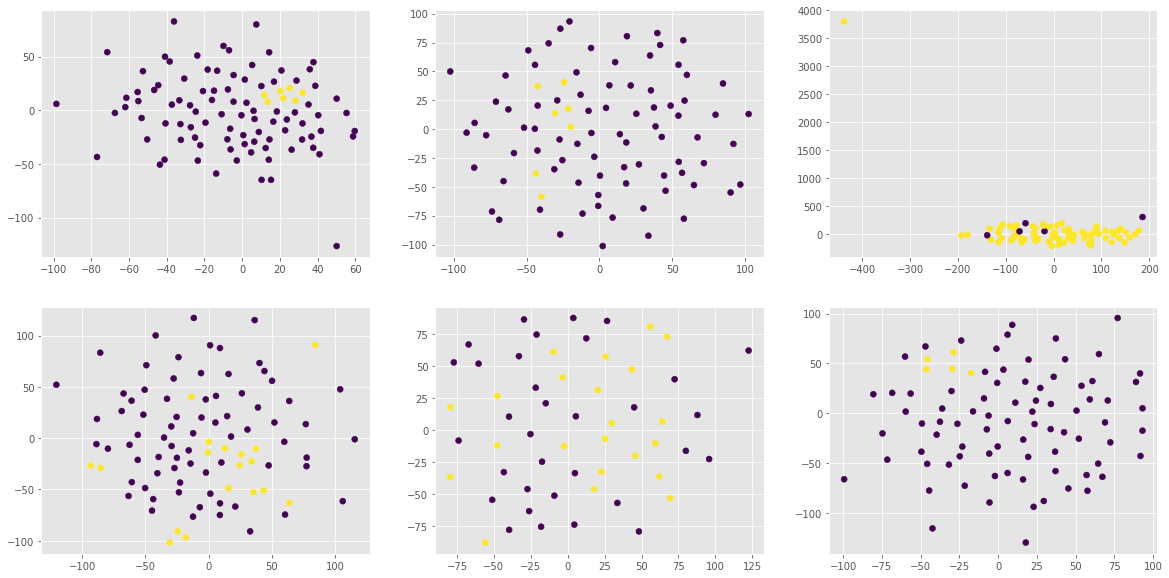

In [0]:
y = docs_merged.target

for (i, group) in enumerate([39, 4, 100, 14, 48, 63]):
  X_embedded = TSNE(
      n_components=2,
      metric='cosine'
        ).fit_transform(
      vectorizer.transform(
          docs_merged[docs_merged.group_id == group].title
          ).toarray(),
      )
  plt.subplot(2, 3, i + 1)
  plt.scatter(X_embedded[::, 0], X_embedded[::, 1],
              c=y[docs_merged.group_id == group])
plt.show()

как интересно! другой формы вышло

In [0]:
clf = RidgeCV(
    alphas=np.logspace(0.1, 10, 100),
    cv=cv, scoring="roc_auc"
    ).fit(X_train, y)
clf_ridge = Ridge(alpha=clf.alpha_)
cross_validation(
    clf_ridge, X_train[::, ::], y, docs_merged.group_id,
     cv, roc_auc_score, use_tqdm=False
     )

0.8834693176116611

100%|██████████| 35/35 [00:03<00:00,  9.70it/s]


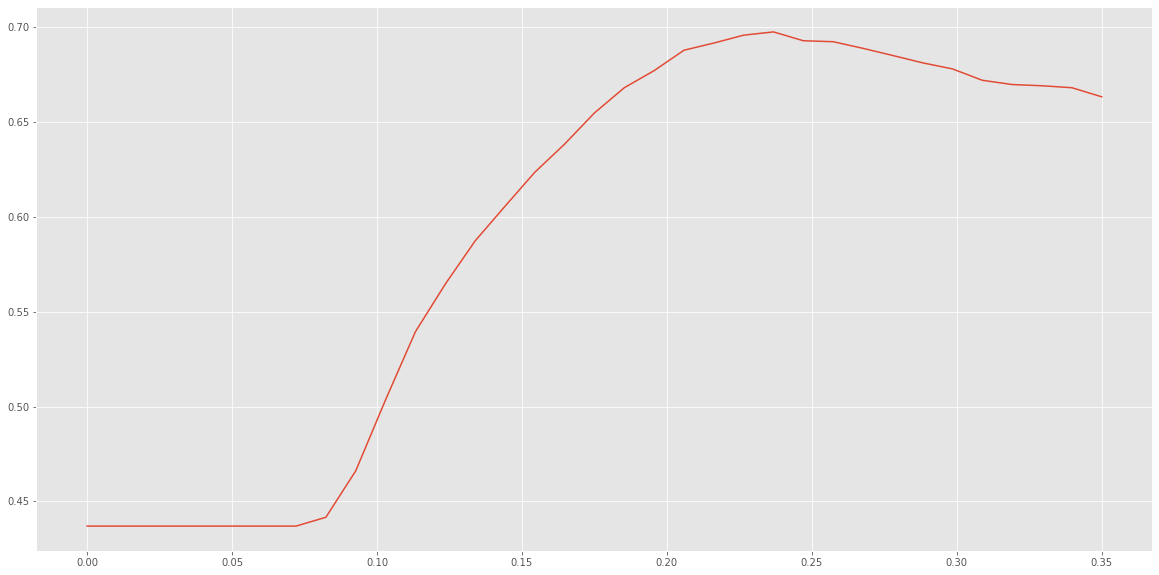

In [0]:
trs, scores = [], []
for treshold in tqdm(np.linspace(0, 0.35, 35)):
  scores.append(cross_validation(
    clf_ridge, X_train[::, ::], y, docs_merged.group_id,
    cv, f1_score, treshold=treshold, use_tqdm=False
    ))
  trs.append(treshold)
plt.plot(trs, scores)
plt.show()

In [0]:
f1_score(y, clf_ridge.predict(X_train) > 0.25)

0.7148387096774194

## Bootstraping!

In [0]:
from sklearn.utils import resample
from sklearn.base import clone

In [0]:
from functools import reduce

In [0]:
class BootstrapClassifier:
  def __init__(self, model, n_divisions=10 ,n_estimators=50):
    self.__model = model
    self.__n_estimators = n_estimators
    self.__n_divisions = n_divisions
    self.__estimators = None
  
  def fit(self, X, y):
    estimators = []
    for _ in range(self.__n_estimators):
      x_est, y_est = resample(
      X, y, stratify=y, n_samples=int(y.shape[0] / self.__n_divisions)
      )
      try:
        clf_est = clone(self.__model)
      except:
        clf_est = self.__model.clone()
      clf_est.fit(x_est, y_est)
      estimators.append(clf_est)
    self.__estimators = estimators

  def predict(self, X):
    return np.apply_along_axis(
        lambda i: self.__estimators[i[0]].predict(X),
        -1,
        np.arange(self.__n_estimators, dtype=int)[::, np.newaxis]
        ).sum(axis=0) >= self.__n_estimators / 2.0

In [0]:
class BootstrapReg:
  def __init__(self, model, n_divisions=10 ,n_estimators=50):
    self.__model = model
    self.__n_estimators = n_estimators
    self.__n_divisions = n_divisions
    self.__estimators = None
  
  def fit(self, X, y):
    estimators = []
    for _ in range(self.__n_estimators):
      x_est, y_est = resample(
      X, y, stratify=y, n_samples=int(y.shape[0] / self.__n_divisions)
      )
      try:
        clf_est = clone(self.__model)
      except:
        clf_est = self.__model.clone()
      clf_est.fit(x_est, y_est)
      estimators.append(clf_est)
    self.__estimators = estimators

  def predict(self, X):
    return np.apply_along_axis(
        lambda i: self.__estimators[i[0]].predict(X),
        -1,
        np.arange(self.__n_estimators, dtype=int)[::, np.newaxis]
        ).sum(axis=0) / self.__n_estimators

In [0]:
class ClassifierFromReg:
  def __init__(self, model, trs):
    self.__model = model
    self.__treshold = trs
  
  def fit(self, X, y):
    self.__model.fit(X, y)

  def predict(self, X):
    return self.__model.predict(X) > self.__treshold

  def clone(self):
    return ClassifierFromReg(clone(self.__model), self.__treshold)


100%|██████████| 10/10 [00:20<00:00,  1.71s/it]


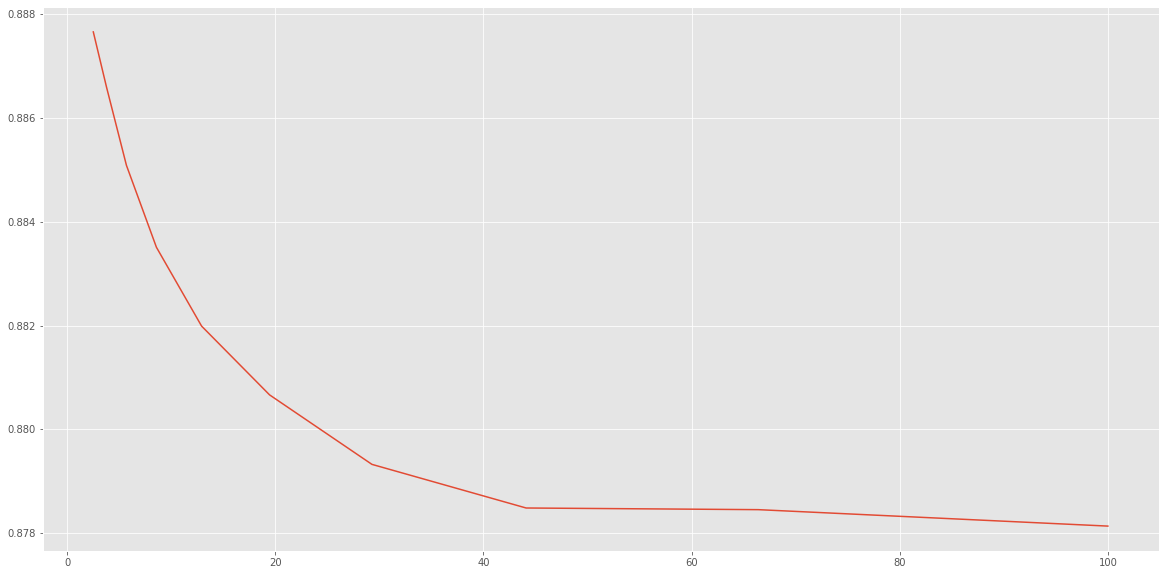

In [0]:
scores = []
divs = []
for n_divisions in tqdm(np.logspace(0.4, 2, 10)):
  scores.append(cross_validation(
    BootstrapReg(clf_ridge, n_divisions=n_divisions),
    X_train, y, docs_merged.group_id,
    cv, roc_auc_score, treshold=None, use_tqdm=False
    ))
  divs.append(n_divisions)
plt.plot(divs, scores)
plt.show()

100%|██████████| 35/35 [02:05<00:00,  3.58s/it]


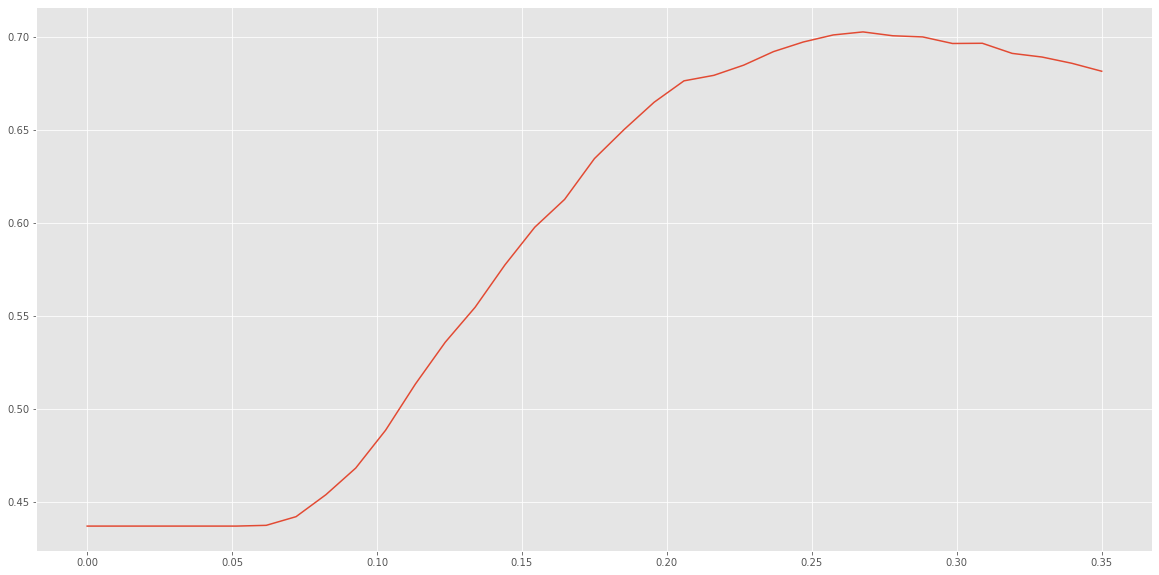

In [0]:
trs, scores = [], []
for treshold in tqdm(np.linspace(0, 0.35, 35)):
  scores.append(cross_validation(
    BootstrapReg(clf_ridge, n_divisions=10**0.4), X_train[::, ::], 
    y, docs_merged.group_id,
    cv, f1_score, treshold=treshold, use_tqdm=False
    ))
  trs.append(treshold)
plt.plot(trs, scores)
plt.show()

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )

In [0]:
dct = {}
pattern = re.compile(r'[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
count = 0
for (doc_id, title) in zip(titles.doc_id, titles.title):
  dct[doc_id] = title
titles_to_merge = []
for doc_id in groups_test.doc_id:
  if doc_id in dct:
    titles_to_merge.append(dct[doc_id])
  else:
    titles_to_merge.append('')
    count += 1
docs_merged = groups_test.copy()
docs_merged["title"] = pd.Series(titles_to_merge)
docs_merged

,pair_id,group_id,doc_id,title
0,11691,130,6710,КАК ПРОПИСАТЬ АДМИНКУ В КС 1.6 СЕБЕ ИЛИ ДРУГУ ...
1,11692,130,4030,Скачать: SGL-RP доработка | Слив мода [MySQL] ...
2,11693,130,5561,Как прописать админку в кс 1.6 - Counter-Strik...
3,11694,130,4055,Как прописать простую админку в кс 1 6
4,11695,130,4247,Подбор админов для сервера по КОД_4 [Архив] -...
...,...,...,...,...
16622,28313,309,16637,Ответы@Mail.Ru: полезно ли кушать творог по ут...
16623,28314,309,16759,Творог. Полезные свойства и лечение творогом. ...
16624,28315,309,15358,Творог - Полезные и опасные свойства творога
16625,28316,309,17287,Ответы@Mail.Ru: Чем полезен творог?


In [0]:
docs_merged.title = docs_merged.title.fillna("")
titles = list(map(
    lambda title: re.findall(pattern, title.lower()),
    docs_merged.title)
)
lemmed_titles = []
for title in titles:
  lemmed_title = []
  for word in title:
    lemmed_title.append(morph.parse(word)[0].normal_form)
  lemmed_titles.append(lemmed_title)
titles = np.asarray(list(map(" ".join, lemmed_titles)))

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
groups_indixes = groups_test.group_id.unique()
X_test = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
      )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:21:]
  X_test.append(features)
X_test = np.vstack(X_test)
X_test = StandardScaler().fit_transform(X_test)

In [0]:
model = BootstrapReg(clf_ridge, 10**0.4)
model.fit(X_train, y)

In [0]:
pred = np.array(model.predict(X_test) > 0.25, dtype=int)

In [0]:
groups_test["target"] = pd.Series(pred)
with open("predict.csv", "w") as f:
  f.write(groups_test.to_csv(columns=("pair_id", "target"), index=False))

Ну, это несколько улучшило конечно результат...

## Clustering

попробуем как-то внутри каждой группы как-то что-то кластеризовать и в качестве фичи добавить расстояние до центроида (или до центроидов?)

In [0]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [0]:
groups_indixes = groups.group_id.unique()
X_train = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
  )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:11:]
  features2 = np.sort(
      KMeans(n_clusters=8, random_state=0).fit_transform(features)
  )
  clusters = AgglomerativeClustering(
      affinity="precomputed", linkage="complete"
      ).fit_predict(pairwise_distances(group_x, metric='cosine')
  )

  values, counts = np.unique(clusters, return_counts=True)
  features3 = clusters == values[np.argmax(counts)]
  X_train.append(np.hstack((features, features2))) #, features3[::, np.newaxis])))
X_train = np.vstack(X_train)
X_train = StandardScaler().fit_transform(X_train)

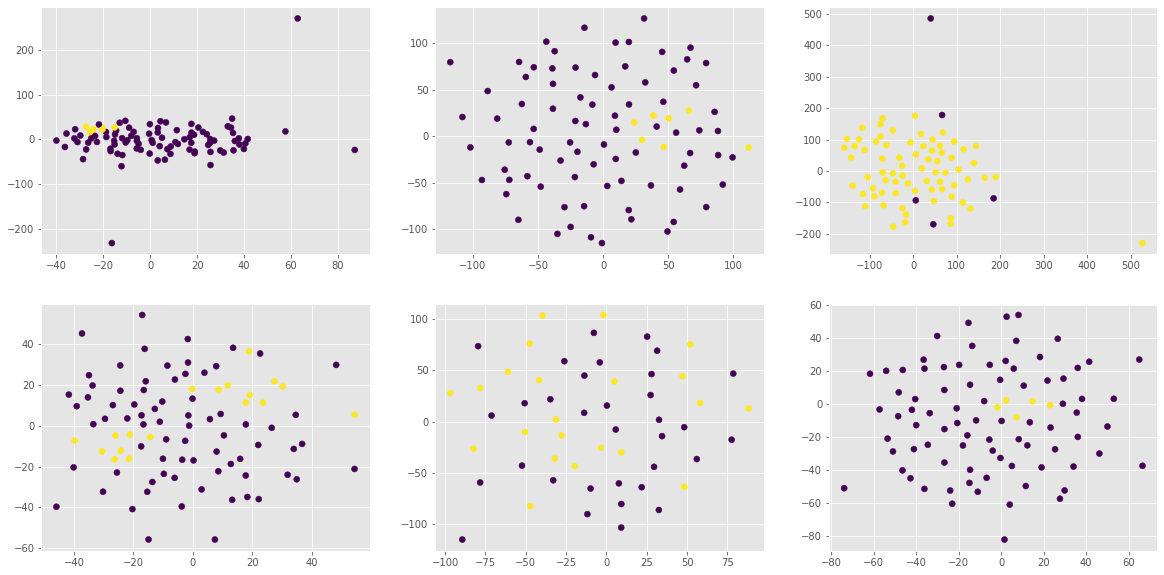

In [0]:
for (i, group) in enumerate([39, 4, 100, 14, 48, 63]):
  X_embedded = TSNE(
      n_components=2,
      metric='cosine'
        ).fit_transform(
      vectorizer.transform(
          docs_merged[docs_merged.group_id == group].title
          ).toarray(),
      )
  plt.subplot(2, 3, i + 1)
  plt.scatter(X_embedded[::, 0], X_embedded[::, 1],
              c=y[docs_merged.group_id == group])
plt.show()

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
from sklearn.model_selection import GridSearchCV

In [0]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": np.arange(2, 10, dtype=int),
    "max_features": [None, "sqrt", "log2"]
}

model = GridSearchCV(
    RandomForestClassifier(n_estimators=30), param_grid=param_grid, cv=cv,
    scoring='f1', n_jobs=-1
    ).fit(X_train, y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
model.best_estimator_.feature_importances_

array([0.03103361, 0.01166747, 0.05176623, 0.12228042, 0.1279296 ,
       0.104957  , 0.10937348, 0.09710649, 0.09583077, 0.05537723,
       0.01084174, 0.01976979, 0.02418162, 0.03648235, 0.03870852,
       0.02996112, 0.01389924, 0.01883331])

In [0]:
model.cv_results_

{'mean_fit_time': array([1.36182761, 0.39917083, 0.39367843, 1.93255506, 0.53665228,
        0.52812319, 2.48404787, 0.65665932, 0.65454812, 3.00355313,
        0.78123357, 0.77636645, 3.51986113, 0.90822425, 0.90380619,
        4.02503495, 1.01272073, 1.01326015, 4.50745597, 1.12918348,
        1.12859962, 4.9638483 , 1.21506639, 1.22175725, 2.3568094 ,
        0.62322533, 0.62165391, 3.41409426, 0.86205437, 0.86293306,
        4.43383164, 1.09552751, 1.10821788, 5.45210121, 1.32645476,
        1.32264907, 6.39016111, 1.5428622 , 1.54366107, 7.21221197,
        1.75158319, 1.74053202, 7.98211813, 1.93600202, 1.92321963,
        8.64573205, 2.08452313, 2.02368658]),
 'mean_score_time': array([0.00934582, 0.00933218, 0.00914941, 0.0106045 , 0.01046572,
        0.01076698, 0.01038795, 0.01013825, 0.00998116, 0.01097369,
        0.01106853, 0.01039767, 0.01145377, 0.01173666, 0.01071119,
        0.01144891, 0.01142104, 0.01175711, 0.0121254 , 0.0126667 ,
        0.01178095, 0.01265037, 0.

In [0]:
clf_forest = model.best_estimator_

In [0]:
cross_validation(
    clf_forest, X_train[::, ::], 
    y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    )

0.7032009180682293

In [0]:
importances = model.best_estimator_.feature_importances_[np.newaxis, ::]
X_train = X_train[::, ::] * importances

In [0]:
clf = RidgeCV(
    alphas=np.logspace(0.1, 10, 100),
    cv=cv, scoring="roc_auc"
    ).fit(X_train, y)
clf_ridge = Ridge(alpha=clf.alpha_)
cross_validation(
    clf_ridge, X_train[::, ::], y, docs_merged.group_id,
     cv, roc_auc_score, use_tqdm=False
     )

0.8914926955009161

100%|██████████| 35/35 [00:03<00:00, 10.21it/s]


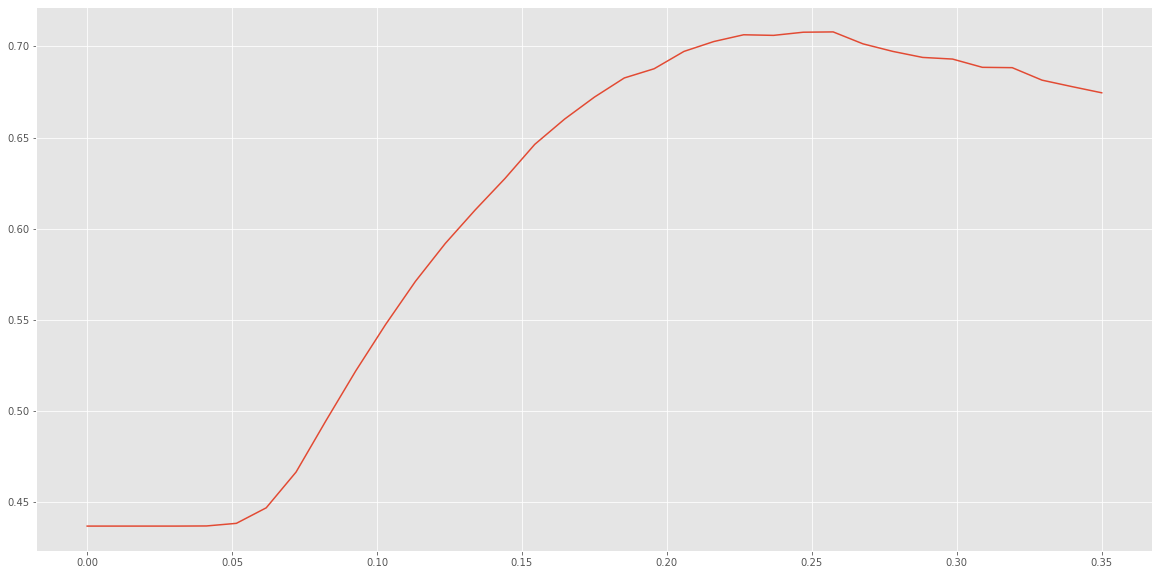

In [0]:
trs, scores = [], []
for treshold in tqdm(np.linspace(0, 0.35, 35)):
  scores.append(cross_validation(
    clf_ridge, X_train[::, ::], 
    y, docs_merged.group_id,
    cv, f1_score, treshold=treshold, use_tqdm=False
    ))
  trs.append(treshold)
plt.plot(trs, scores)
plt.show()

In [0]:
max_trs = trs[np.argmax(scores)]
trs[np.argmax(scores)], np.max(scores)

(0.25735294117647056, 0.7079972410869396)

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )

In [0]:
dct = {}
# pattern = re.compile(r'[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
count = 0
for (doc_id, title) in zip(titles.doc_id, titles.title):
  dct[doc_id] = title
titles_to_merge = []
for doc_id in groups_test.doc_id:
  if doc_id in dct:
    titles_to_merge.append(dct[doc_id])
  else:
    titles_to_merge.append('')
    count += 1
docs_merged = groups_test.copy()
docs_merged["title"] = pd.Series(titles_to_merge)
docs_merged

,pair_id,group_id,doc_id,title
0,11691,130,6710,КАК ПРОПИСАТЬ АДМИНКУ В КС 1.6 СЕБЕ ИЛИ ДРУГУ ...
1,11692,130,4030,Скачать: SGL-RP доработка | Слив мода [MySQL] ...
2,11693,130,5561,Как прописать админку в кс 1.6 - Counter-Strik...
3,11694,130,4055,Как прописать простую админку в кс 1 6
4,11695,130,4247,Подбор админов для сервера по КОД_4 [Архив] -...
...,...,...,...,...
16622,28313,309,16637,Ответы@Mail.Ru: полезно ли кушать творог по ут...
16623,28314,309,16759,Творог. Полезные свойства и лечение творогом. ...
16624,28315,309,15358,Творог - Полезные и опасные свойства творога
16625,28316,309,17287,Ответы@Mail.Ru: Чем полезен творог?


In [0]:
docs_merged.title = docs_merged.title.fillna("")
titles = list(map(
    lambda title: re.findall(pattern, title.lower()),
    docs_merged.title)
)
lemmed_titles = []
for title in titles:
  lemmed_title = []
  for word in title:
    lemmed_title.append(morph.parse(word)[0].normal_form)
  lemmed_titles.append(lemmed_title)
titles = np.asarray(list(map(" ".join, lemmed_titles)))

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), token_pattern=pattern)
vectorizer.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False,
                token_pattern=re.compile('[a-z]+\\-?[a-z]*\\.[a-z]{2}|[а-я]+\\-?[а-я]*\\.[а-я]{2}|[а-я]+\\-?[а-я]*|[a-z]+\\-?[a-z]*|[0-9]+'),
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
groups_indixes = groups_test.group_id.unique()
X_test = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
  )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:11:]
  features2 = np.sort(
      KMeans(n_clusters=8, random_state=0).fit_transform(features)
      )
  clusters = AgglomerativeClustering().fit_predict(features)
  
  values, counts = np.unique(clusters, return_counts=True)
  features3 = clusters == values[np.argmax(counts)]
  X_test.append(np.hstack((features, features2))) #, features3[::, np.newaxis])))
X_test = np.vstack(X_test)
X_test = StandardScaler().fit_transform(X_test)

In [0]:
X_test = X_test * importances

In [0]:
pred = np.asarray(clf_ridge.predict(X_test) > trs[np.argmax(scores)], dtype=int)

In [0]:
groups_test["target"] = pd.Series(pred)
with open("predict.csv", "w") as f:
  f.write(groups_test.to_csv(columns=("pair_id", "target"), index=False))

## Clustering + Bootstraping

черт его знает, что из этого выйдет, но интересно же

100%|██████████| 50/50 [01:36<00:00,  1.45s/it]


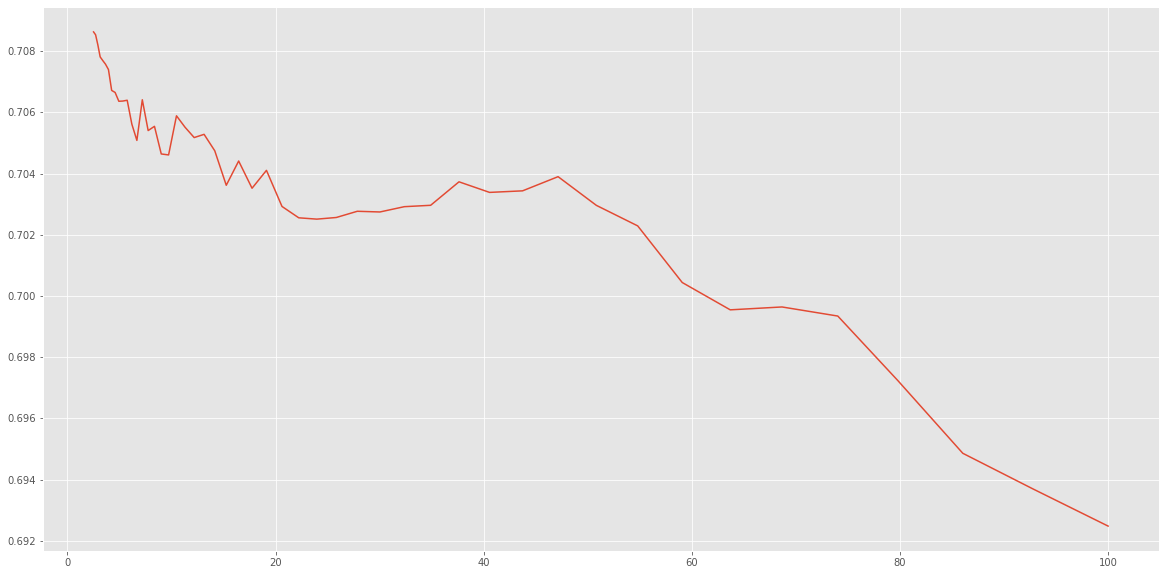

In [0]:
scores = []
divs = []
for n_divisions in tqdm(np.logspace(0.4, 2, 50)):
  scores.append(cross_validation(
    BootstrapClassifier(ClassifierFromReg(clf_ridge, max_trs),
                        n_divisions=n_divisions),
    X_train, y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    ))
  divs.append(n_divisions)
plt.plot(divs, scores)
plt.show()

In [0]:
np.max(scores), divs[np.argmax(scores)]

(0.708633327900446, 2.51188643150958)

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )

In [0]:
dct = {}
# pattern = re.compile(r'[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
count = 0
for (doc_id, title) in zip(titles.doc_id, titles.title):
  dct[doc_id] = title
titles_to_merge = []
for doc_id in groups_test.doc_id:
  if doc_id in dct:
    titles_to_merge.append(dct[doc_id])
  else:
    titles_to_merge.append('')
    count += 1
docs_merged = groups_test.copy()
docs_merged["title"] = pd.Series(titles_to_merge)
docs_merged

,pair_id,group_id,doc_id,title
0,11691,130,6710,КАК ПРОПИСАТЬ АДМИНКУ В КС 1.6 СЕБЕ ИЛИ ДРУГУ ...
1,11692,130,4030,Скачать: SGL-RP доработка | Слив мода [MySQL] ...
2,11693,130,5561,Как прописать админку в кс 1.6 - Counter-Strik...
3,11694,130,4055,Как прописать простую админку в кс 1 6
4,11695,130,4247,Подбор админов для сервера по КОД_4 [Архив] -...
...,...,...,...,...
16622,28313,309,16637,Ответы@Mail.Ru: полезно ли кушать творог по ут...
16623,28314,309,16759,Творог. Полезные свойства и лечение творогом. ...
16624,28315,309,15358,Творог - Полезные и опасные свойства творога
16625,28316,309,17287,Ответы@Mail.Ru: Чем полезен творог?


In [0]:
docs_merged.title = docs_merged.title.fillna("")
titles = list(map(
    lambda title: re.findall(pattern, title.lower()),
    docs_merged.title)
)
lemmed_titles = []
for title in titles:
  lemmed_title = []
  for word in title:
    lemmed_title.append(morph.parse(word)[0].normal_form)
  lemmed_titles.append(lemmed_title)
titles = np.asarray(list(map(" ".join, lemmed_titles)))

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), token_pattern=pattern)
vectorizer.fit(titles)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False,
                token_pattern=re.compile('[а-я]+\\-?[а-я]*|[a-z]+\\-?[a-z]*|[0-9]+'),
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
groups_indixes = groups_test.group_id.unique()
X_test = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
  )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:11:]
  features2 = np.sort(
      KMeans(n_clusters=8, random_state=0).fit_transform(features)
      )
  clusters = AgglomerativeClustering().fit_predict(features)
  
  values, counts = np.unique(clusters, return_counts=True)
  features3 = clusters == values[np.argmax(counts)]
  X_test.append(np.hstack((features, features2))) #, features3[::, np.newaxis])))
X_test = np.vstack(X_test)
X_test = StandardScaler().fit_transform(X_test)

In [0]:
X_test = X_test * importances

In [0]:
model = BootstrapClassifier(
    ClassifierFromReg(clf_ridge, max_trs),
    n_divisions=divs[np.argmax(scores)]
    )
model.fit(X_train, y)
pred = np.asarray(model.predict(X_test), dtype=int)

In [0]:
groups_test["target"] = pd.Series(pred)
with open("predict.csv", "w") as f:
  f.write(groups_test.to_csv(columns=("pair_id", "target"), index=False))

## Stacking (first and overfitted)

Обучим RandomForestClassifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
depths = range(1, 10)

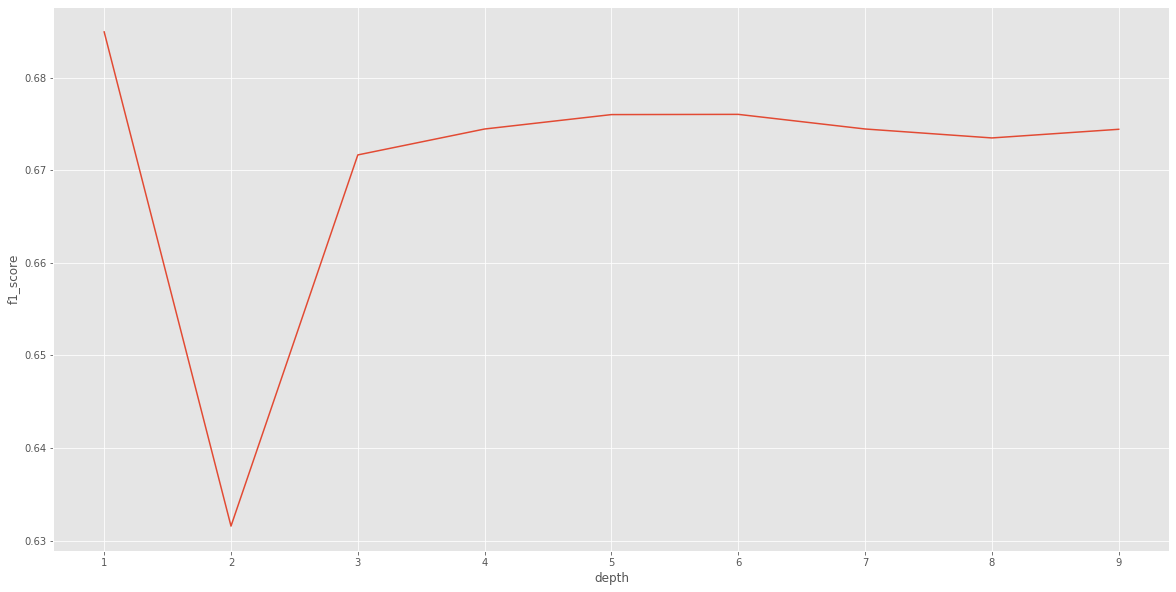

In [0]:
x = []
f1 = []
for depth in depths:
  clf_forest = RandomForestClassifier(
      random_state=123, n_estimators=50, n_jobs=-1, max_depth=depth
      )
  x.append(depth)
  f1.append(cross_validation(
      clf_forest, X_train[::, ::], y, docs_merged.group_id,
      cv, f1_score, treshold=0.5, use_tqdm=False
      ))
plt.plot(x, f1)
plt.xlabel("depth")
plt.ylabel("f1_score")
plt.show()

In [0]:
clf_forest = RandomForestClassifier(
    random_state=123, n_estimators=50, n_jobs=-1, max_depth=1
    )

AdaBoostClassifier

In [0]:
from sklearn.ensemble import AdaBoostClassifier

In [0]:
clf_adaboost = AdaBoostClassifier(random_state=123)

In [0]:
cross_validation(
    clf_adaboost, X_train[::, ::], y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    )

0.6675012949623799

Попробуем теперь все это дело как-то стекать. Для этого будем использовать Voting Classifier с весами
UPD Я сделал более упоротое что-то, построив трехмерные векторы матожиданий классов для классификаторов и значения регрессиии, чтобы на этом настраивать метаалгоритм
Почему матожидание? Ну, у нас там деревья всякие, adaboost. Результаты голосования мне казались сами по себе достаточно интересными.

In [0]:
class RegressorFromClassifier:
  def __init__(self, clf):
    self.__clf = clf
  def fit(self, X, y):
    self.__clf.fit(X, y)
  def predict(self, X):
    pred = self.__clf.predict_proba(X)
    return self.__clf.classes_[0] * pred[::, 0] \
    + self.__clf.classes_[1] * pred[::, 1]

In [0]:
from sklearn.model_selection import KFold

In [0]:
def get_x_for_stacking(X, y, cv, estimators):
  X_res = np.zeros((X.shape[0], 3))
  for train, meta in cv.split(X_train, y):
    pred = []
    for estimator in estimators:
      estimator.fit(X[train], y[train])
      pred.append(estimator.predict(X[meta]))
    X_res[meta] = np.array(pred).T
  return X_res

In [0]:
estimators = [
              clf_ridge,
              RegressorFromClassifier(clf_forest),
              RegressorFromClassifier(clf_adaboost)
]

In [0]:
X_stacking = get_x_for_stacking(X_train, y, cv, estimators)
X_stacking = StandardScaler().fit_transform(X_stacking)
#X_embedded = TSNE().fit_transform(X_stacking[::])
#plt.scatter(X_embedded[::, 0], X_embedded[::, 1], c=y[::])
#plt.show()

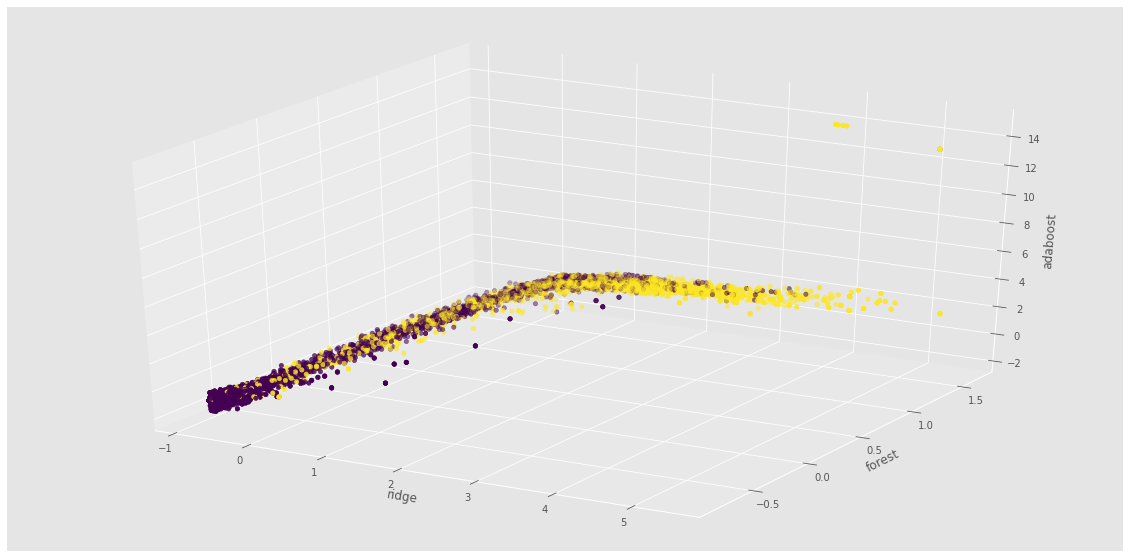

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_stacking[::,0], X_stacking[::,1], X_stacking[::,2], c=y)
#ax.set_xlim(-1.0, 1.0)
#ax.set_ylim(-1.0, 1.0)
#ax.set_zlim(-1.0, 1.0)
ax.set_xlabel("ridge")
ax.set_ylabel("forest")
ax.set_zlabel("adaboost")
plt.show()

In [0]:
meta_clf = RidgeCV(
    cv=cv, scoring='roc_auc', alphas=np.logspace(1.0, 3, 100)
    ).fit(X_stacking, y)
meta_clf.alpha_

1000.0

In [0]:
meta_clf2 = Ridge(alpha=meta_clf.alpha_)
cross_validation(
    meta_clf2, X_stacking[::, ::], y, docs_merged.group_id,
    cv, roc_auc_score, use_tqdm=False
    )

0.889306063059174

100%|██████████| 50/50 [00:04<00:00, 10.89it/s]


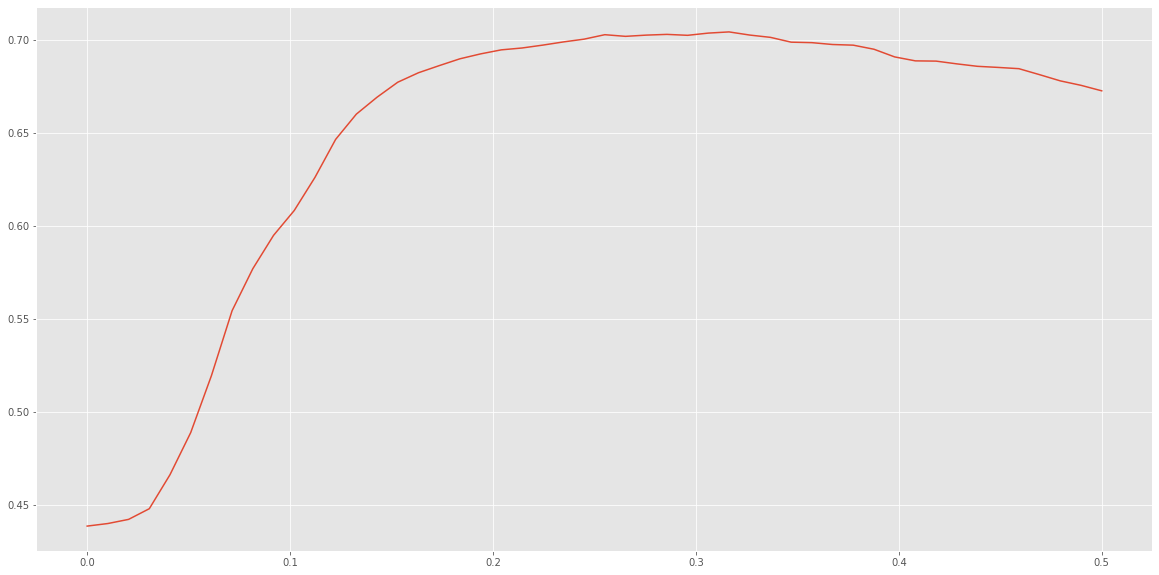

In [0]:
trs, scores = [], []
for treshold in tqdm(np.linspace(0, 0.5, 50)):
  scores.append(cross_validation(
    meta_clf2, X_stacking[::, ::], y, docs_merged.group_id,
    cv, f1_score, treshold=treshold, use_tqdm=False
    ))
  trs.append(treshold)
plt.plot(trs, scores)
plt.show()

In [0]:
meta_clf3 = LogisticRegressionCV(cv=cv, scoring='f1')
meta_clf3.fit(X_stacking, y)
meta_clf4 = LogisticRegression(C=meta_clf3.C_[0])
cross_validation(
    meta_clf4, X_stacking[::, ::], y, docs_merged.group_id,
    cv, f1_score, treshold=0.5, use_tqdm=False
    )


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence 

0.6658209218669465

In [0]:
scores[31]

0.7040863251886478

In [0]:
for estimator in estimators:
  estimator.fit(X_train, y)

Сделаем наши предсказания на тесте

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )

In [0]:
dct = {}
pattern = re.compile(r'[а-я]+\-?[а-я]*|[a-z]+\-?[a-z]*|[0-9]+')
count = 0
for (doc_id, title) in zip(titles.doc_id, titles.title):
  dct[doc_id] = title
titles_to_merge = []
for doc_id in groups_test.doc_id:
  if doc_id in dct:
    titles_to_merge.append(dct[doc_id])
  else:
    titles_to_merge.append('')
    count += 1
docs_merged = groups_test.copy()
docs_merged["title"] = pd.Series(titles_to_merge)
docs_merged

,pair_id,group_id,doc_id,title
0,11691,130,6710,КАК ПРОПИСАТЬ АДМИНКУ В КС 1.6 СЕБЕ ИЛИ ДРУГУ ...
1,11692,130,4030,Скачать: SGL-RP доработка | Слив мода [MySQL] ...
2,11693,130,5561,Как прописать админку в кс 1.6 - Counter-Strik...
3,11694,130,4055,Как прописать простую админку в кс 1 6
4,11695,130,4247,Подбор админов для сервера по КОД_4 [Архив] -...
...,...,...,...,...
16622,28313,309,16637,Ответы@Mail.Ru: полезно ли кушать творог по ут...
16623,28314,309,16759,Творог. Полезные свойства и лечение творогом. ...
16624,28315,309,15358,Творог - Полезные и опасные свойства творога
16625,28316,309,17287,Ответы@Mail.Ru: Чем полезен творог?


In [0]:
docs_merged.title = docs_merged.title.fillna("")
titles = list(map(
    lambda title: re.findall(pattern, title.lower()),
    docs_merged.title)
)
lemmed_titles = []
for title in titles:
  lemmed_title = []
  for word in title:
    lemmed_title.append(morph.parse(word)[0].normal_form)
  lemmed_titles.append(lemmed_title)
titles = np.asarray(list(map(" ".join, lemmed_titles)))

In [0]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
vectorizer.fit(titles)


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
groups_indixes = groups_test.group_id.unique()
X_test = []

for group_id in groups_indixes:
  group_x = vectorizer.transform(
      titles[docs_merged.group_id == group_id]
      )
  features = np.sort(np.asarray(
      pairwise_distances(group_x, metric='cosine')
      ))[::,1:21:]
  X_test.append(features)
X_test = np.vstack(X_test)
X_test = StandardScaler().fit_transform(X_test)

In [0]:
estimators_pred = []
meta_clf2.fit(X_stacking, y)
for estimator in estimators:
  estimators_pred.append(estimator.predict(X_test))
X_stacking_test = np.array(estimators_pred).T
X_stacking_test = StandardScaler().fit_transform(X_stacking_test)

In [0]:
pred = np.array(meta_clf2.predict(X_stacking_test) > 0.31, dtype=int)

In [0]:
groups_test["target"] = pd.Series(pred)
with open("predict.csv", "w") as f:
    f.write(groups_test.to_csv(columns=("pair_id", "target"), index=False))

## Random forest classifier! Не зря я его обучил

In [0]:
clf_forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
groups_test = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/test_groups.csv",
     sep=","
     )
titles = pd.read_csv(
    "/content/drive/My Drive/Colab Notebooks/docs_titles.tsv",
     sep="\t"
     )